In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('train (1).csv')
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
print('================================')
print('========= DATASET INFO =========')
print(train.info())
print('================================')

========= DATASET INFO =========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None


In [4]:
train.shape

(913000, 4)

In [5]:
train['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [6]:
train['item'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [7]:
train['date'] = pd.to_datetime(train['date'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [8]:
# Keep original columns (store/item) so we can create per-store/item features
train = train.copy()

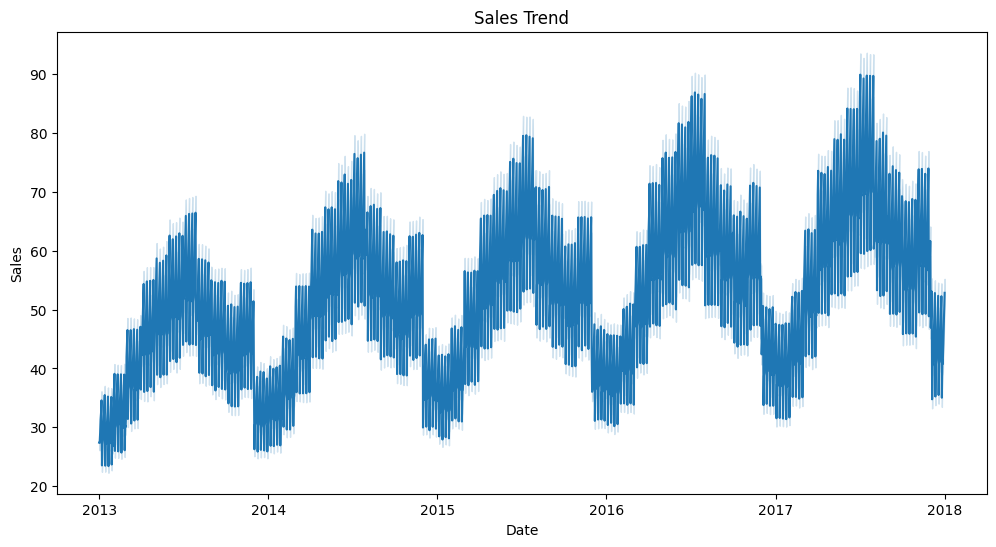

In [9]:
plt.figure(figsize=(12,6))
sns.lineplot(data=train, x='date', y='sales')
plt.title('Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

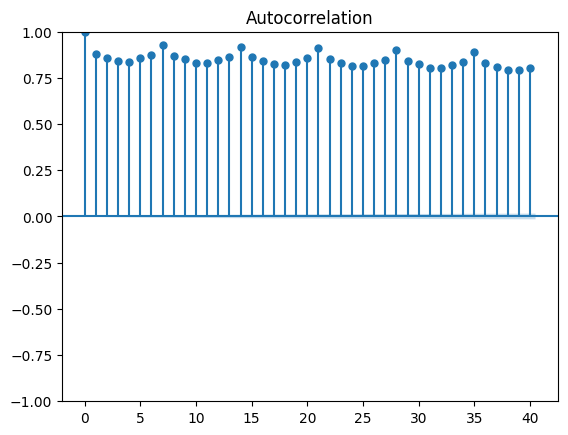

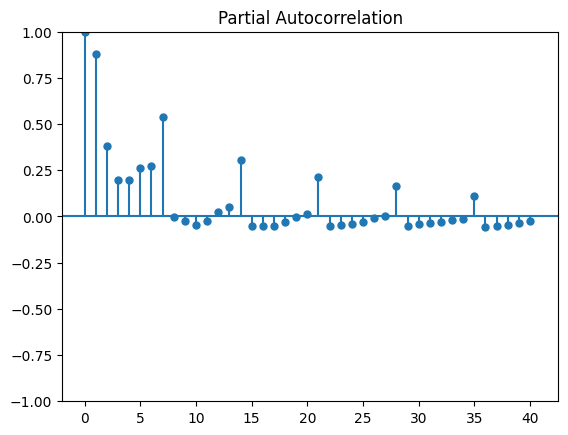

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ensure ts is a datetime-indexed series
ts = train.set_index('date')['sales']

plot_acf(ts, lags=40)
plot_pacf(ts, lags=40, method='ywm')
plt.show()

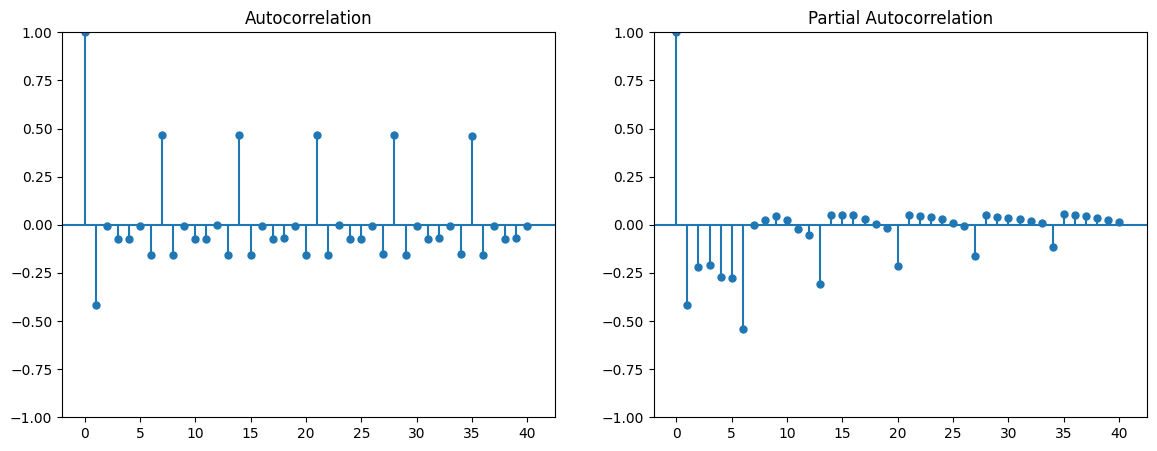

In [30]:
ts_diff = ts.diff().dropna()


fig, ax = plt.subplots(1, 2, figsize=(14,5))

plot_acf(ts_diff, lags=40, ax=ax[0])
plot_pacf(ts_diff, lags=40, ax=ax[1], method='ywm')

plt.show()

In [34]:
ts_ds = ts.resample('1H').mean()

C:\Users\bryant\AppData\Local\Temp\ipykernel_6960\3778513687.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_ds = ts.resample('1H').mean()


In [36]:
split = int(len(ts_ds) * 0.8)

train = ts_ds.iloc[:split]
test  = ts_ds.iloc[split:]

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

models = [
    (2,1,0, 0,1,1,7),
    (3,1,0, 0,1,1,7),
    (2,1,1, 0,1,1,7),
    (3,1,1, 0,1,1,7),
]

In [40]:
model = SARIMAX(
    ts_ds,
    order=(2,1,0),
    enforce_stationarity=False,
    enforce_invertibility=False
)

result = model.fit()
print(result.summary())


c:\Users\bryant\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\bryant\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\bryant\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\bryant\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\bryant\AppData\Local\Programs\

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                43801
Model:               SARIMAX(2, 1, 0)   Log Likelihood                     nan
Date:                Mon, 22 Dec 2025   AIC                                nan
Time:                        15:08:39   BIC                                nan
Sample:                    01-01-2013   HQIC                               nan
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0        nan        nan        nan         nan         nan
ar.L2               0        nan        nan        nan         nan         nan
sigma2            nan        nan        nan        n

In [41]:
forecast = result.forecast(steps=len(test))
forecast.index = test.index

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test.values
y_pred = forecast.values

mae  = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

# MAPE aman (hindari division by zero)
mape = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


ValueError: Input contains NaN.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title("Actual vs Forecast")
plt.show()


In [ ]:
result.plot_diagnostics(figsize=(12,8))
plt.show()

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(result.resid.dropna(), lags=40)
plt.show()


NameError: name 'result' is not defined

In [11]:
numerical_col = train.select_dtypes(include =['number']).columns

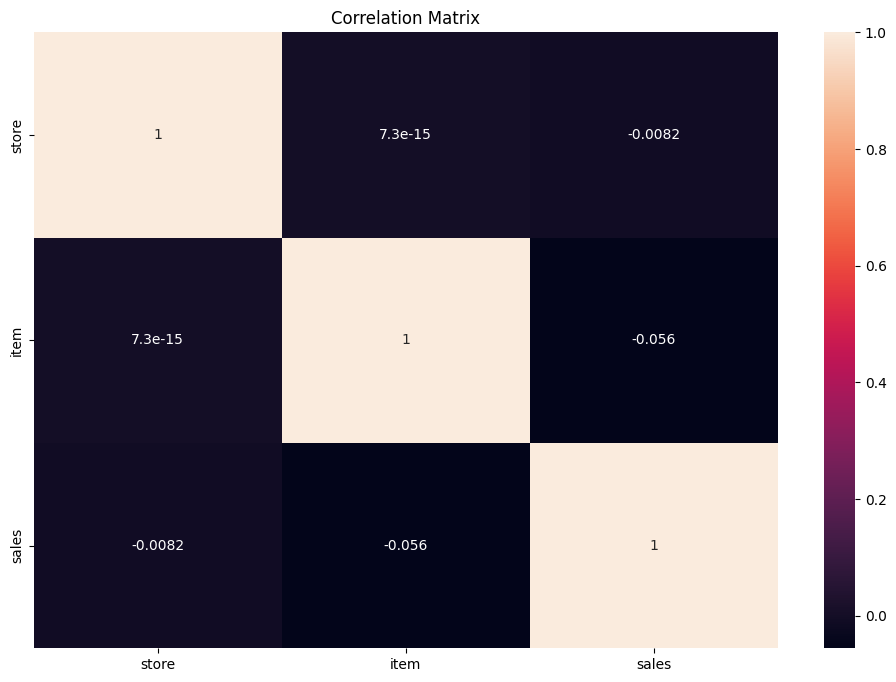

In [12]:
corr = train[numerical_col].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr,annot = True)
plt.title('Correlation Matrix')
plt.show()

In [13]:
def create_date_features(df):
    df = df.copy()
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    return df

In [14]:
train['date'] = pd.to_datetime(train['date'])
train = create_date_features(train)
train.head()

,date,store,item,sales,year,month,day,dayofweek,dayofyear,weekofyear,is_weekend,is_month_start,is_month_end
0,2013-01-01,1,1,13,2013,1,1,1,1,1,0,1,0
1,2013-01-02,1,1,11,2013,1,2,2,2,1,0,0,0
2,2013-01-03,1,1,14,2013,1,3,3,3,1,0,0,0
3,2013-01-04,1,1,13,2013,1,4,4,4,1,0,0,0
4,2013-01-05,1,1,10,2013,1,5,5,5,1,1,0,0


In [15]:
def add_rolling_windows(df):
    df = df.copy()

    lags = [7, 14, 21, 28]
    windows = [7, 14, 21, 28]

    # Determine grouping for per-store/item features if available
    if {'store','item'}.issubset(df.columns):
        group_cols = ['store','item']
    elif 'store' in df.columns:
        group_cols = ['store']
    else:
        group_cols = None

    if group_cols:
        df = df.sort_values(group_cols + ['date'])
        for lag in lags:
            df[f'lag_{lag}'] = df.groupby(group_cols)['sales'].shift(lag)
        for window in windows:
            df[f'rolling_mean_{window}'] = df.groupby(group_cols)['sales'].transform(lambda x: x.shift(1).rolling(window).mean())
            df[f'rolling_std_{window}'] = df.groupby(group_cols)['sales'].transform(lambda x: x.shift(1).rolling(window).std())
    else:
        # global features when no grouping columns present
        df = df.sort_values('date')
        for lag in lags:
            df[f'lag_{lag}'] = df['sales'].shift(lag)
        for window in windows:
            df[f'rolling_mean_{window}'] = df['sales'].shift(1).rolling(window).mean()
            df[f'rolling_std_{window}'] = df['sales'].shift(1).rolling(window).std()

    return df


In [16]:
print("Creating lag & rolling features...")
train = add_rolling_windows(train)
train.head()

Creating lag & rolling features...


,date,store,item,sales,year,month,day,dayofweek,dayofyear,weekofyear,...,lag_21,lag_28,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_21,rolling_std_21,rolling_mean_28,rolling_std_28
0,2013-01-01,1,1,13,2013,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11,2013,1,2,2,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14,2013,1,3,3,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13,2013,1,4,4,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10,2013,1,5,5,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


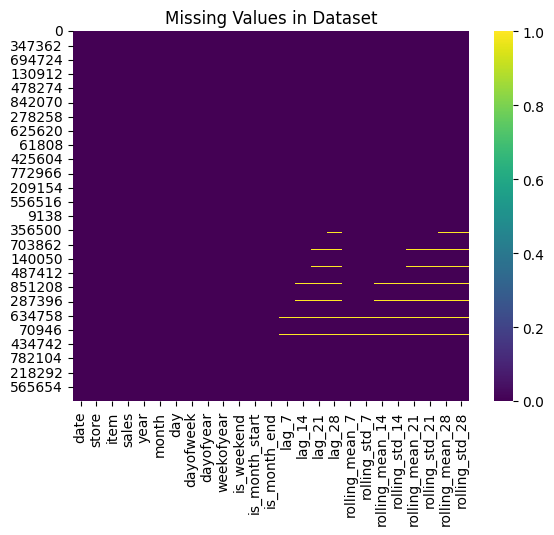

In [17]:
sns.heatmap(train.isnull(),cmap='viridis')
plt.title('Missing Values in Dataset')
plt.show()

In [18]:
train = train.dropna().reset_index(drop=True)

In [19]:
train = train.sort_values(['date'])

In [20]:
train = add_rolling_windows(train)

In [21]:
def time_series_split_per_store(df, date_col='date', test_size=50):
    train_list = []
    test_list = []

    # Prefer splitting per store (and item if available) to preserve time order per series
    if 'store' in df.columns:
        group_cols = ['store'] if 'item' not in df.columns else ['store','item']
        for _, g in df.groupby(group_cols):
            g = g.sort_values(date_col)
            if len(g) <= test_size:
                continue
            train_list.append(g.iloc[:-test_size])
            test_list.append(g.iloc[-test_size:])
    else:
        g = df.sort_values(date_col)
        train_list.append(g.iloc[:-test_size])
        test_list.append(g.iloc[-test_size:])

    train = pd.concat(train_list) if train_list else pd.DataFrame()
    test = pd.concat(test_list) if test_list else pd.DataFrame()

    return train, test


In [22]:
train_df, test_df = time_series_split_per_store(train)

In [23]:
FEATURES = [c for c in train_df.columns if c not in ['sales', 'date']]
train_df = train_df.dropna()
test_df  = test_df.dropna()

X_train = train_df[FEATURES]
y_train = train_df['sales']

X_test = test_df[FEATURES]
y_test = test_df['sales']

In [24]:
test_df.isnull().sum()

date               0
store              0
item               0
sales              0
year               0
month              0
day                0
dayofweek          0
dayofyear          0
weekofyear         0
is_weekend         0
is_month_start     0
is_month_end       0
lag_7              0
lag_14             0
lag_21             0
lag_28             0
rolling_mean_7     0
rolling_std_7      0
rolling_mean_14    0
rolling_std_14     0
rolling_mean_21    0
rolling_std_21     0
rolling_mean_28    0
rolling_std_28     0
dtype: int64

In [25]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [26]:
FEATURES = [c for c in train_df.columns if c not in ['sales', 'date']]

model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='l2'
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3235
[LightGBM] [Info] Number of data points in the train set: 860000, number of used features: 23
[LightGBM] [Info] Start training from score 52.973864


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=1000,
              random_state=42, subsample=0.8)

In [27]:
test_df['pred_sales'] = model.predict(X_test)

In [28]:
mae = mean_absolute_error(y_test, test_df['pred_sales'])
rmse = mean_squared_error(y_test, test_df['pred_sales'], squared=False)  # returns RMSE when squared=False
# Safe MAPE: avoid division by zero by replacing zeros in y_test with small number
y_nonzero = y_test.replace(0, 1e-8)
mape = np.mean(np.abs((y_test - test_df['pred_sales']) / y_nonzero)) * 100

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

TypeError: got an unexpected keyword argument 'squared'

In [ ]:
import matplotlib.pyplot as plt

store_id = test_df['store'].iloc[0]

plot_df = test_df[test_df['store'] == store_id]

plt.figure(figsize=(14,5))
plt.plot(plot_df['date'], plot_df['sales'], label='Actual', marker='o')
plt.plot(plot_df['date'], plot_df['pred_sales'], label='Forecast', marker='x')
plt.title(f'Forecast vs Actual - Store {store_id}')
plt.legend()
plt.grid()
plt.show()


KeyError: 'store'

C:\Users\bryant\AppData\Local\Temp\ipykernel_15808\2404012448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['error'] = plot_df['sales'] - plot_df['pred_sales']


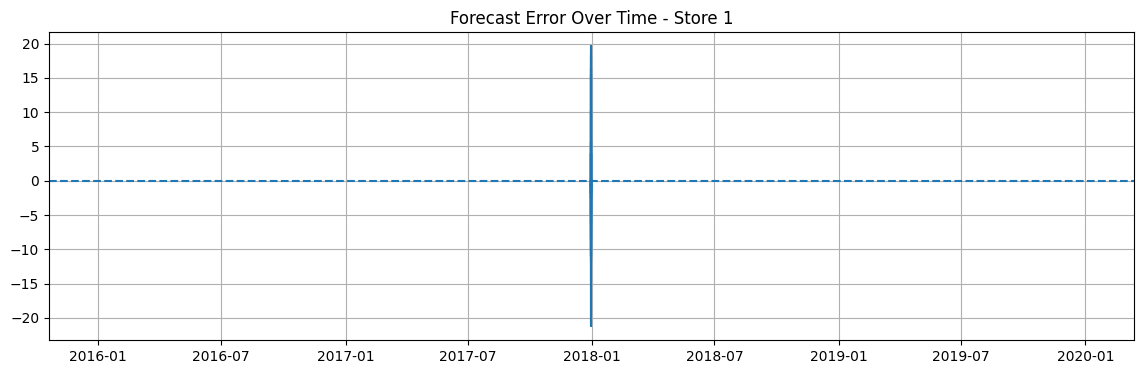

In [ ]:
plot_df['error'] = plot_df['sales'] - plot_df['pred_sales']

plt.figure(figsize=(14,4))
plt.plot(plot_df['date'], plot_df['error'])
plt.axhline(0, linestyle='--')
plt.title(f'Forecast Error Over Time - Store {store_id}')
plt.grid()
plt.show()

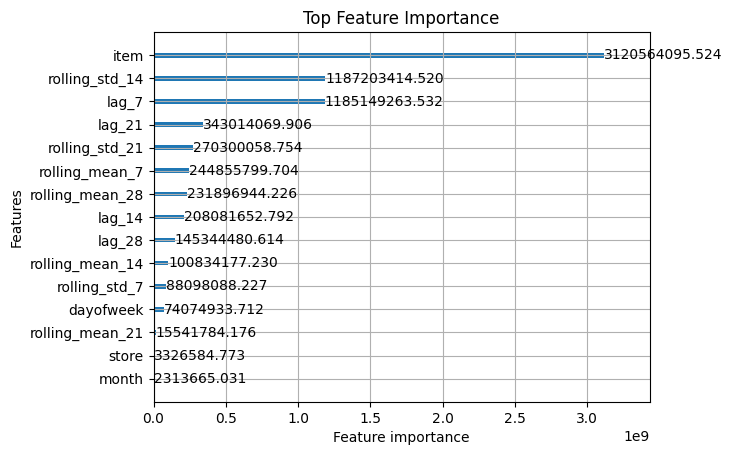

In [ ]:
lgb.plot_importance(model, max_num_features=15, importance_type='gain')
plt.title('Top Feature Importance')
plt.show()


In [52]:
ts_ds = (
    ts
    .resample('1H')
    .mean()
    .dropna()
)

C:\Users\bryant\AppData\Local\Temp\ipykernel_6960\1510596054.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('1H')


In [55]:
ts_ds = pd.to_numeric(ts_ds, errors='coerce')
ts_ds = ts_ds.dropna()

In [56]:
df = pd.DataFrame({'y': ts_ds})

lags = [1,2,3,7,14]

for l in lags:
    df[f'lag_{l}'] = df['y'].shift(l)

df['rolling_7']  = df['y'].rolling(7).mean()
df['rolling_14'] = df['y'].rolling(14).mean()

print("Before dropna:", df.shape)
df = df.dropna()
print("After dropna:", df.shape)


Before dropna: (1826, 8)
After dropna: (1812, 8)


In [57]:
split = int(len(df) * 0.8)
train, test = df.iloc[:split], df.iloc[split:]

X_train = train.drop(columns='y')
y_train = train['y']

X_test  = test.drop(columns='y')
y_test  = test['y']


In [58]:
import lightgbm as lgb

model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31
)

model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1449, number of used features: 7
[LightGBM] [Info] Start training from score 50.798534


LGBMRegressor(learning_rate=0.05, n_estimators=500)

In [60]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np

# Prediksi
y_pred = model.predict(X_test)

# Metrik
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
mape = np.mean(np.abs((y_test - y_pred) / np.clip(y_test, 1e-8, None))) * 100

# Tabel metrik
metrics_df = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "MAPE (%)"],
    "Value":  [mae, rmse, mape]
})

metrics_df

,Metric,Value
0,MAE,1.498821
1,RMSE,2.407975
2,MAPE (%),2.628102


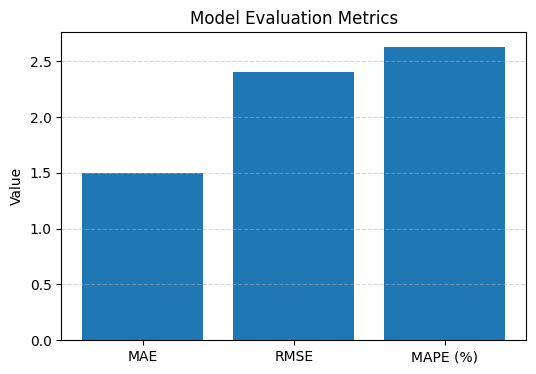

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(metrics_df["Metric"], metrics_df["Value"])
plt.title("Model Evaluation Metrics")
plt.ylabel("Value")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

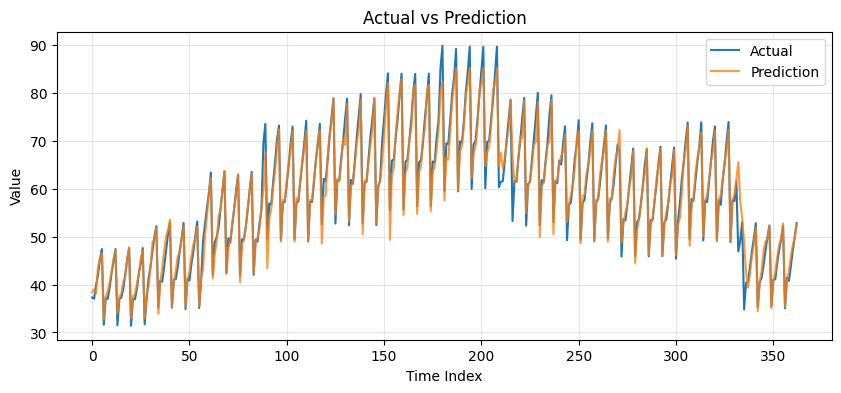

In [62]:
plt.figure(figsize=(10,4))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Prediction", alpha=0.8)
plt.title("Actual vs Prediction")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

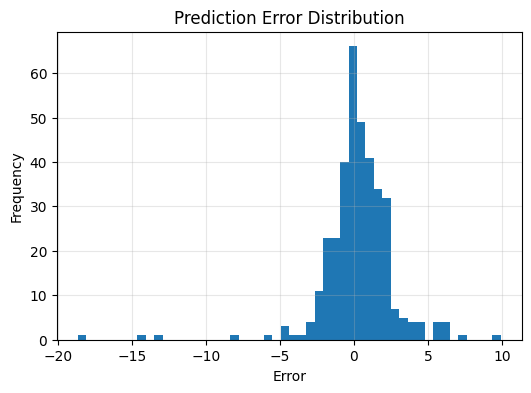

In [63]:
errors = y_test - y_pred

plt.figure(figsize=(6,4))
plt.hist(errors, bins=50)
plt.title("Prediction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()
